# MATH 441 Project 3: Energy Production Optimization

**Environmental Impact Minimization with Mixed Integer Programming**

In [12]:
%pip install cvxpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp
import seaborn as sns
from matplotlib.ticker import PercentFormatter
import matplotlib.colors as mcolors

Note: you may need to restart the kernel to use updated packages.


## 1. Problem Statement

We need to determine the optimal mix of energy production facilities to minimize environmental impact while meeting energy demands. Different energy sources (coal, natural gas, nuclear, etc.) have varying environmental impacts, production capacities, and costs. The energy demand and production efficiency vary by time of day and season.

## 2. Mathematical Formulation

### Sets
- $i \in I$: Types of energy sources (coal, natural gas, nuclear, hydro, solar, wind, geothermal)
- $p \in P$: Time periods (morning, noon, evening, night)
- $s \in S$: Seasons (winter, spring, summer, fall)

### Parameters
- $co2_i$: CO₂ emissions (units/h) per facility of energy type $i$
- $air_i$: Air pollution (units/h) per facility of energy type $i$
- $water_i$: Water pollution (units/h) per facility of energy type $i$
- $prod_i$: Base production capacity (MW/h) per facility of energy type $i$
- $build_i$: Construction cost (million $) per facility of energy type $i$
- $maint_i$: Maintenance cost ($/h) per facility of energy type $i$
- $trans_i$: Transportation cost ($/MW) per facility of energy type $i$
- $eff_{ips}$: Efficiency factor for energy source $i$ during period $p$ in season $s$
- $B$: Total available budget for construction (million $)
- $D_{ps}$: Hourly electricity demand (MW) during period $p$ in season $s$
- $H_{ps}$: Number of hours in period $p$ of season $s$ per year
- $w_{co2}$, $w_{air}$, $w_{water}$: Weights for different environmental impacts

### Decision Variables
- $x_i$: Number of facilities to build of energy type $i$ (integer)

### Objective Function
Minimize the weighted total environmental impact:
$$\min \sum_{i \in I} (w_{co2} \cdot co2_i + w_{air} \cdot air_i + w_{water} \cdot water_i) \cdot x_i \cdot \sum_{p \in P}\sum_{s \in S} H_{ps}$$

### Constraints

#### Budget Constraint
$$\sum_{i \in I} build_i \cdot x_i \leq B$$

#### Demand Constraints
For each time period and season, production must meet demand:
$$\sum_{i \in I} prod_i \cdot eff_{ips} \cdot x_i \geq D_{ps} \quad \forall p \in P, s \in S$$

#### Non-negativity and Integer Constraints
$$x_i \geq 0 \text{ and integer} \quad \forall i \in I$$

## 3. Data Loading and Preprocessing

In [30]:
# Load the data
data = pd.read_csv('data_project3(version_R)(1).CSV')
data.head()

,Energy Source,Production (MW/h),CO? Emissions (unit/h),Air Pollution (unit/h),Water Pollution (unit/h),Cost to Produce ($/h),Cost to build(million $),Cost to Maintain ($/h),Cost to Transport ($/M),Winter Morning,...,Spring Evening,Spring Night,Summer Morning,Summer Noon,Summer Evening,Summer Night,Fall Morning,Fall Noon,Fall Evening,Fall Night
0,Coal,1100,18.0,15.2,12.5,65,1000,30,10,6,...,6,6,6,6,6,6,6,6,6,6
1,Natural Gas,1000,9.0,7.5,5.8,50,1900,20,8,3,...,5,3,4,5,6,4,3,5,5,3
2,Nuclear,1050,0.5,0.5,8.0,25,10000,50,5,6,...,6,6,6,6,6,6,6,6,6,6
3,Hydro,755,0.2,1.8,4.5,20,3000,20,2,2,...,6,5,5,6,6,5,3,5,6,5
4,Solar,700,0.1,0.8,0.1,40,2500,10,2,2,...,3,0,4,6,4,0,3,5,3,0


In [31]:
# Extract basic parameters
energy_sources = data['Energy Source'].values
production = data['Production (MW/h)'].values
co2_emissions = data['CO? Emissions (unit/h)'].values
air_pollution = data['Air Pollution (unit/h)'].values
water_pollution = data['Water Pollution (unit/h)'].values
prod_cost = data['Cost to Produce ($/h)'].values
build_cost = data['Cost to build(million $)'].values
maint_cost = data['Cost to Maintain ($/h)'].values
trans_cost = data['Cost to Transport ($/M)'].values

# Extract time-season efficiency factors
seasons = ['Winter', 'Spring', 'Summer', 'Fall']
periods = ['Morning', 'Noon', 'Evening', 'Night']
efficiency_columns = [f"{season} {period}" for season in seasons for period in periods]

# Create a matrix for efficiency factors: sources x (periods x seasons)
efficiency_matrix = data[efficiency_columns].values

# Reshape to 3D array: sources x periods x seasons
efficiency_3d = np.zeros((len(energy_sources), len(periods), len(seasons)))
for i, source in enumerate(energy_sources):
    for p, period in enumerate(periods):
        for s, season in enumerate(seasons):
            col_name = f"{season} {period}"
            col_index = efficiency_columns.index(col_name)
            efficiency_3d[i, p, s] = efficiency_matrix[i, col_index]

print(f"Loaded data for {len(energy_sources)} energy sources across {len(periods)} periods and {len(seasons)} seasons.")
print(efficiency_3d)

Loaded data for 7 energy sources across 4 periods and 4 seasons.
[[[6. 6. 6. 6.]
  [6. 6. 6. 6.]
  [6. 6. 6. 6.]
  [6. 6. 6. 6.]]

 [[3. 3. 4. 3.]
  [5. 5. 5. 5.]
  [4. 5. 6. 5.]
  [6. 3. 4. 3.]]

 [[6. 6. 6. 6.]
  [6. 6. 6. 6.]
  [6. 6. 6. 6.]
  [6. 6. 6. 6.]]

 [[2. 3. 5. 3.]
  [2. 5. 6. 5.]
  [3. 6. 6. 6.]
  [3. 5. 5. 5.]]

 [[2. 3. 4. 3.]
  [3. 5. 6. 5.]
  [2. 3. 4. 3.]
  [0. 0. 0. 0.]]

 [[5. 4. 3. 4.]
  [3. 6. 2. 3.]
  [6. 5. 4. 5.]
  [6. 5. 5. 5.]]

 [[6. 6. 6. 6.]
  [6. 6. 6. 6.]
  [6. 6. 6. 6.]
  [6. 6. 6. 6.]]]


In [32]:
working_hours = np.sum(efficiency_3d, axis=(1, 2))
print(working_hours)

[96. 69. 96. 70. 43. 71. 96.]


## 4. Visualization of Energy Source Characteristics

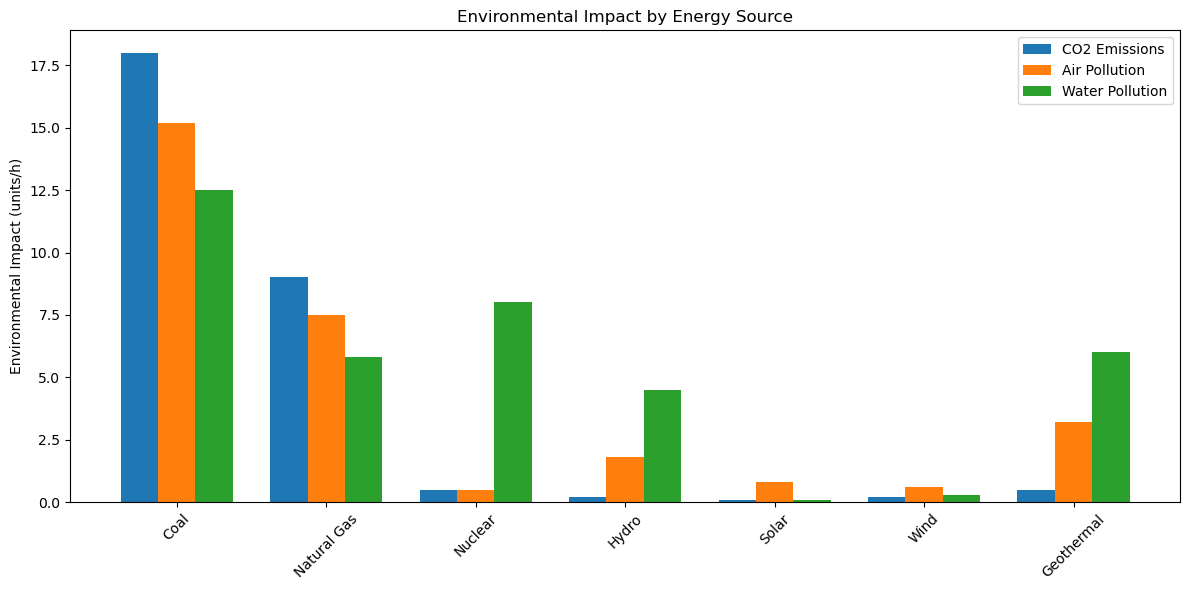

In [33]:
# Plot environmental impacts
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(energy_sources))
width = 0.25

ax.bar(x - width, co2_emissions, width, label='CO2 Emissions')
ax.bar(x, air_pollution, width, label='Air Pollution')
ax.bar(x + width, water_pollution, width, label='Water Pollution')

ax.set_xticks(x)
ax.set_xticklabels(energy_sources)
ax.legend()
ax.set_ylabel('Environmental Impact (units/h)')
ax.set_title('Environmental Impact by Energy Source')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

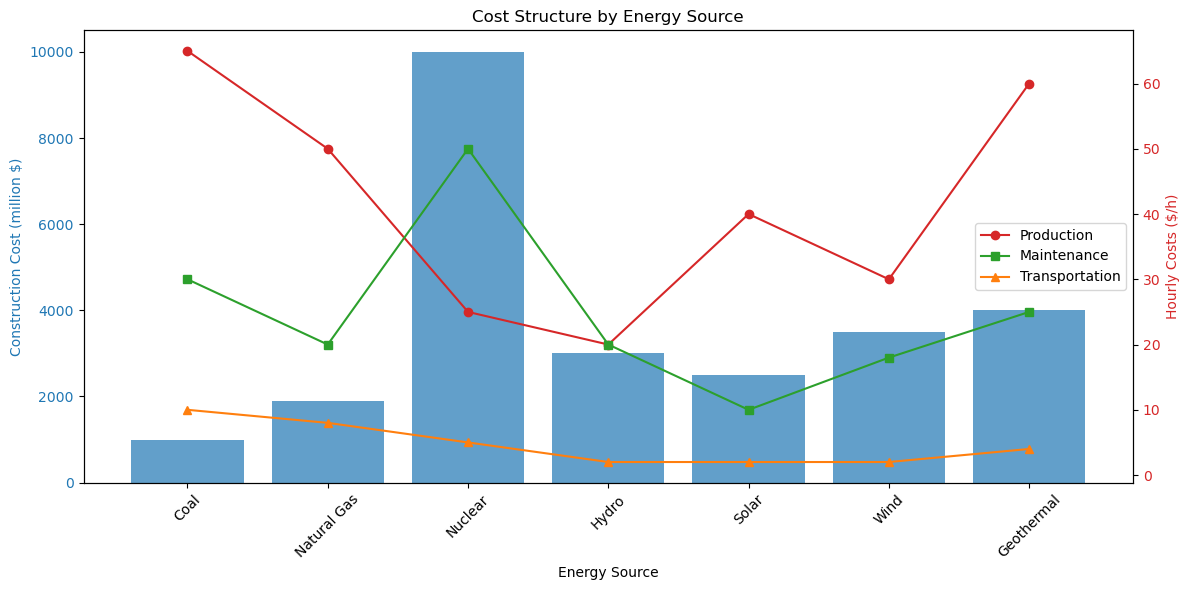

In [34]:
# Plot costs
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Energy Source')
ax1.set_ylabel('Construction Cost (million $)', color=color)
ax1.bar(energy_sources, build_cost, color=color, alpha=0.7)
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(rotation=45)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Hourly Costs ($/h)', color=color)
ax2.plot(energy_sources, prod_cost, 'o-', color='tab:red', label='Production')
ax2.plot(energy_sources, maint_cost, 's-', color='tab:green', label='Maintenance')
ax2.plot(energy_sources, trans_cost, '^-', color='tab:orange', label='Transportation')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend()

plt.title('Cost Structure by Energy Source')
plt.tight_layout()
plt.show()

## 5. Heatmap of Efficiency Factors

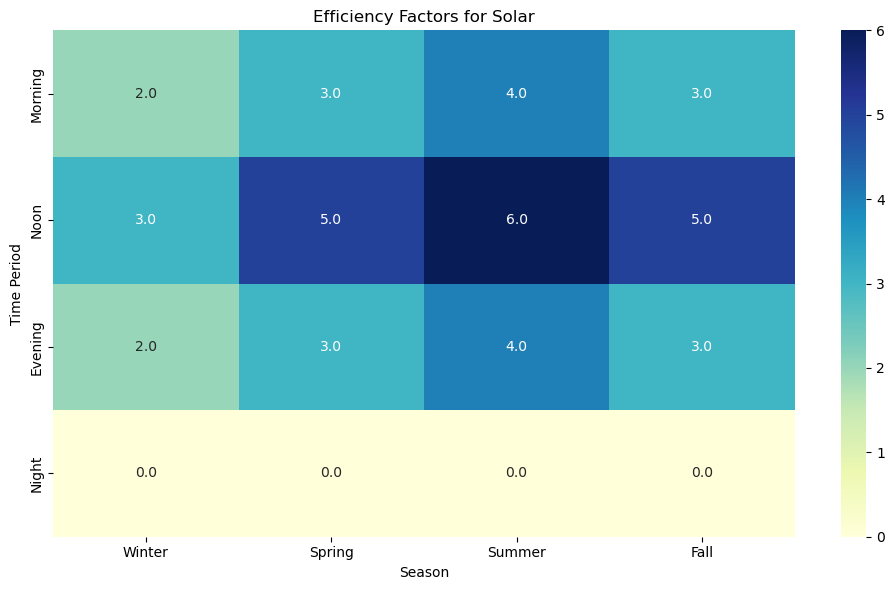

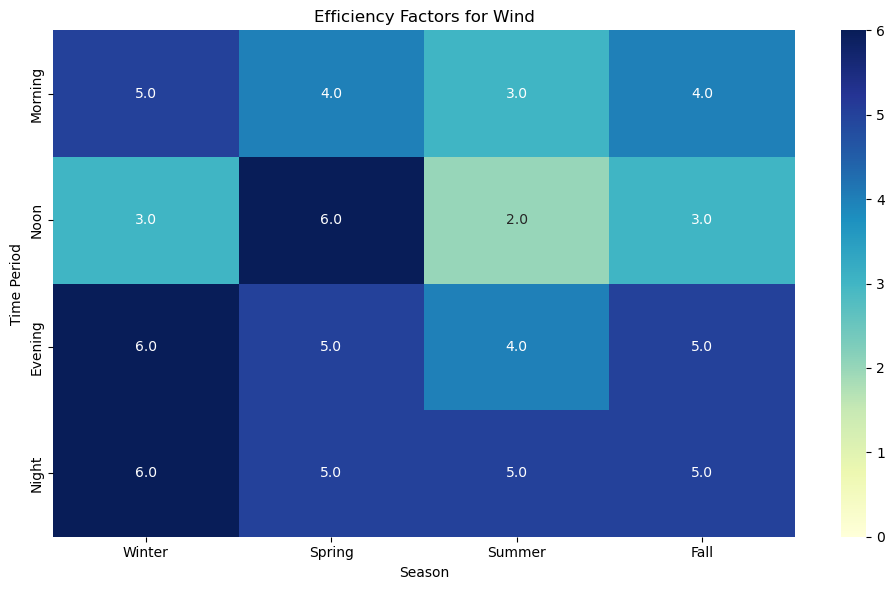

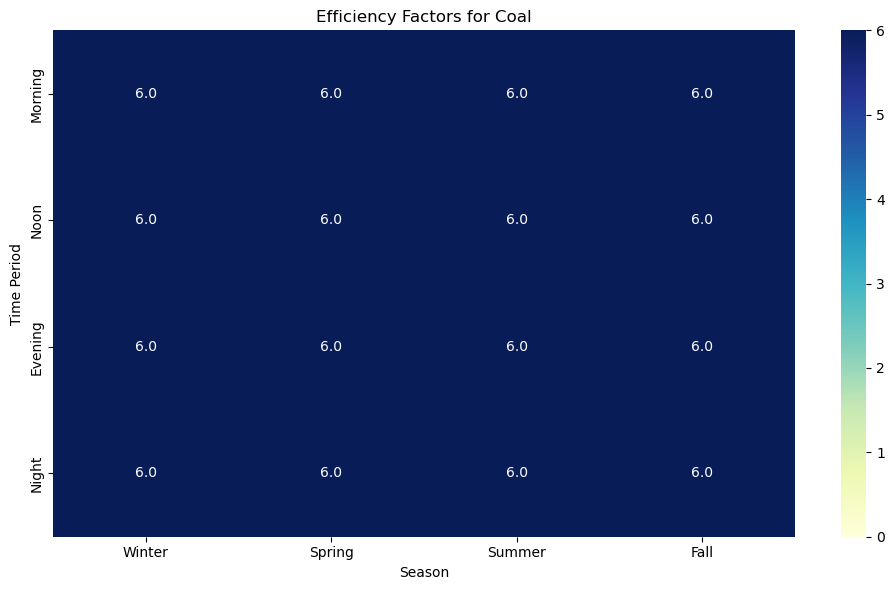

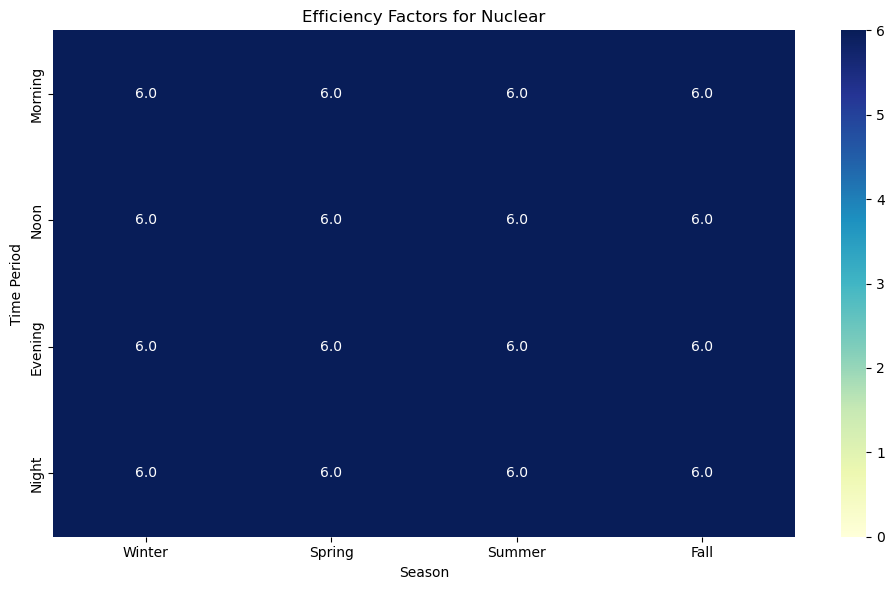

In [35]:
# Create a function to plot heatmap for a specific energy source
def plot_efficiency_heatmap(source_index, source_name):
    efficiency_data = efficiency_3d[source_index]
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(efficiency_data, annot=True, fmt=".1f", 
                xticklabels=seasons, yticklabels=periods,
                cmap="YlGnBu", vmin=0, vmax=6)
    plt.title(f'Efficiency Factors for {source_name}')
    plt.ylabel('Time Period')
    plt.xlabel('Season')
    plt.tight_layout()
    plt.show()

# Plot for a few selected sources
for i, source in enumerate(['Solar', 'Wind', 'Coal', 'Nuclear']):
    if source in energy_sources:
        source_idx = np.where(energy_sources == source)[0][0]
        plot_efficiency_heatmap(source_idx, source)

## 6. Model Parameters Setup

In [36]:
# Set the budget constraint
construct_budget = 100000  # in million $

# Set demand for each period and season
# For this example, we'll create a demand matrix
# Higher demand during day, lower at night
# Higher demand in winter and summer (heating/cooling)
base_demand = 45000  # Base demand in MW
demand = np.zeros((len(periods), len(seasons)))

# Seasonal variations
season_factors = {'Winter': 1.3, 'Spring': 0.8, 'Summer': 1.2, 'Fall': 0.9}
# Period variations
period_factors = {'Morning': 1.1, 'Noon': 1.3, 'Evening': 1.4, 'Night': 0.7}

for p, period in enumerate(periods):
    for s, season in enumerate(seasons):
        demand[p, s] = base_demand * season_factors[season] * period_factors[period]

# Hours in each period-season combination
# Assume: 90 days per season, periods are: morning (6h), noon (6h), evening (6h), night (6h)
hours_per_period = 6
days_per_season = 90
hours = np.full((len(periods), len(seasons)), hours_per_period * days_per_season)

# Set impact weights
w_co2 = 0.1
w_air = 0.3
w_water = 0.6

## 7. Optimization Model

In [37]:
# Number of energy sources
n = len(energy_sources)

# Decision variables: number of facilities for each energy source
x = cp.Variable(n, integer=True)

# weight for environmental factor
W1 = 0.5

# weight for economic factor
W2 = 0.5

# Environmental impact weights
env_impact = w_co2 * co2_emissions + w_air * air_pollution + w_water * water_pollution

# Total hours per year
total_hours = np.sum(hours)

print(total_hours)

# Objective: Minimize weighted environmental impact
objective = cp.Minimize((cp.sum(cp.multiply(env_impact * working_hours, x)) * W1 + cp.sum(cp.multiply(prod_cost * working_hours, x))  * W2))

# Constraints
constraints = []

# Construction budget constraint
constraints.append(cp.sum(cp.multiply(build_cost, x)) <= construct_budget)

# Demand constraints for each period and season
for p in range(len(periods)):
    for s in range(len(seasons)):
        # Calculate effective production for each source in this period-season
        effective_prod = np.array([production[i] * efficiency_3d[i, p, s] for i in range(n)])
        constraints.append(cp.sum(cp.multiply(effective_prod, x)) >= demand[p, s])

# energy type constraints
for i in range(n):
    constraints.append(x[i] <= 0.25*cp.sum(x))

# Non-negativity constraints
constraints.append(x >= 0)

# Create and solve the problem
prob = cp.Problem(objective, constraints)
prob.solve(solver=cp.GLPK_MI, verbose=True)

8640
                                     CVXPY                                     
                                     v1.6.4                                    
(CVXPY) Mar 17 10:45:14 PM: Your problem has 7 variables, 31 constraints, and 0 parameters.
(CVXPY) Mar 17 10:45:14 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 17 10:45:14 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 17 10:45:14 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Mar 17 10:45:14 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 17 10:45:14 PM: Compiling problem (target solver=GLPK_M

31083.57

## 8. Results Analysis

In [38]:
# Check if the problem was solved successfully
print(f"Problem status: {prob.status}")
if prob.status == 'optimal':
    print(f"Optimal value: {prob.value:.2f} environmental impact units")
    
    # Extract optimal solution
    optimal_facilities = np.round(x.value).astype(int)
    
    # Create a dataframe for results
    results = pd.DataFrame({
        'Energy Source': energy_sources,
        'Number of Facilities': optimal_facilities,
        'Production Capacity (MW/h)': production * optimal_facilities,
        'CO2 Emissions (unit/h)': co2_emissions * optimal_facilities,
        'Air Pollution (unit/h)': air_pollution * optimal_facilities,
        'Water Pollution (unit/h)': water_pollution * optimal_facilities,
        'Construction Cost (million $)': build_cost * optimal_facilities
    })
    
    print("\nOptimal Energy Mix:")
    print(results[['Energy Source', 'Number of Facilities']])
    
    print(f"\nTotal Construction Cost: ${results['Construction Cost (million $)'].sum()} million")
    print(f"Available Budget: ${construct_budget} million")
    
    # Calculate total environmental impact
    total_co2 = np.sum(results['CO2 Emissions (unit/h)']) * total_hours
    total_air = np.sum(results['Air Pollution (unit/h)']) * total_hours
    total_water = np.sum(results['Water Pollution (unit/h)']) * total_hours
    
    print(f"\nAnnual Environmental Impact:")
    print(f"CO2 Emissions: {total_co2:.2f} units")
    print(f"Air Pollution: {total_air:.2f} units")
    print(f"Water Pollution: {total_water:.2f} units")
else:
    print("Problem could not be solved to optimality.")

Problem status: optimal
Optimal value: 31083.57 environmental impact units

Optimal Energy Mix:
  Energy Source  Number of Facilities
0          Coal                     1
1   Natural Gas                     5
2       Nuclear                     5
3         Hydro                     5
4         Solar                     1
5          Wind                     5
6    Geothermal                     0

Total Construction Cost: $95500 million
Available Budget: $100000 million

Annual Environmental Impact:
CO2 Emissions: 584064.00 units
Air Pollution: 587520.00 units
Water Pollution: 912384.00 units


## 9. Visualizations of Results

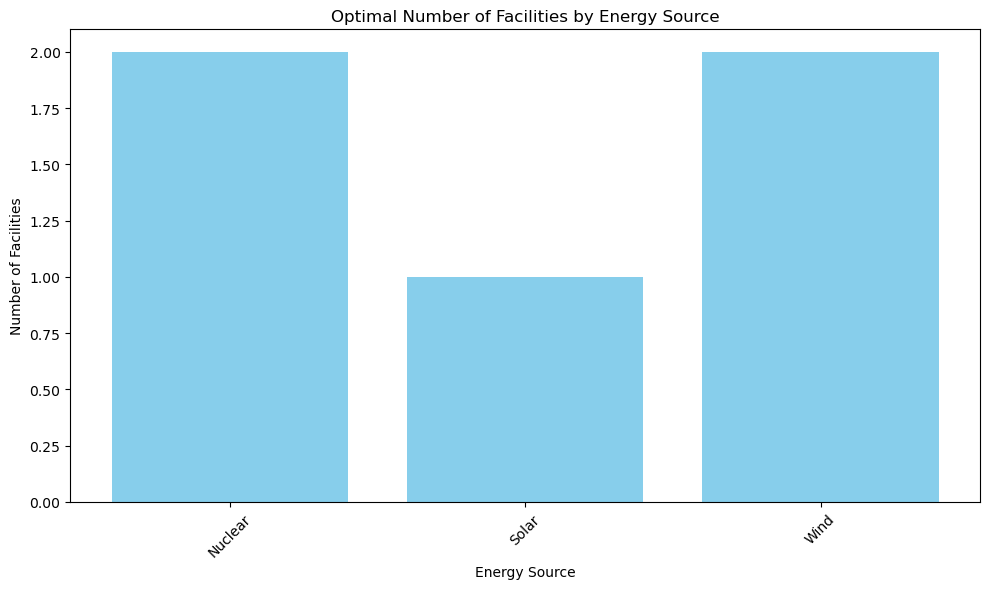

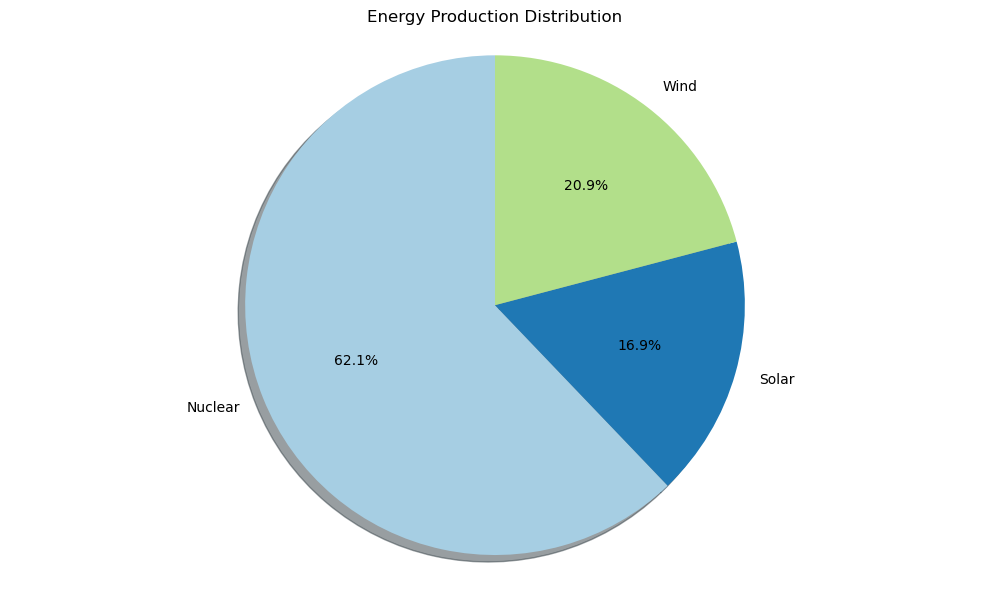

In [67]:
if prob.status == 'optimal':
    # Filter sources that are used in the optimal solution
    used_sources = results[results['Number of Facilities'] > 0]
    
    # Plotting the optimal energy mix
    plt.figure(figsize=(10, 6))
    plt.bar(used_sources['Energy Source'], used_sources['Number of Facilities'], color='skyblue')
    plt.title('Optimal Number of Facilities by Energy Source')
    plt.xlabel('Energy Source')
    plt.ylabel('Number of Facilities')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Pie chart of energy contribution
    production_mix = used_sources['Production Capacity (MW/h)']
    labels = used_sources['Energy Source']
    
    plt.figure(figsize=(10, 6))
    plt.pie(production_mix, labels=labels, autopct='%1.1f%%', 
            startangle=90, shadow=True, colors=plt.cm.Paired.colors)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    plt.title('Energy Production Distribution')
    plt.tight_layout()
    plt.show()

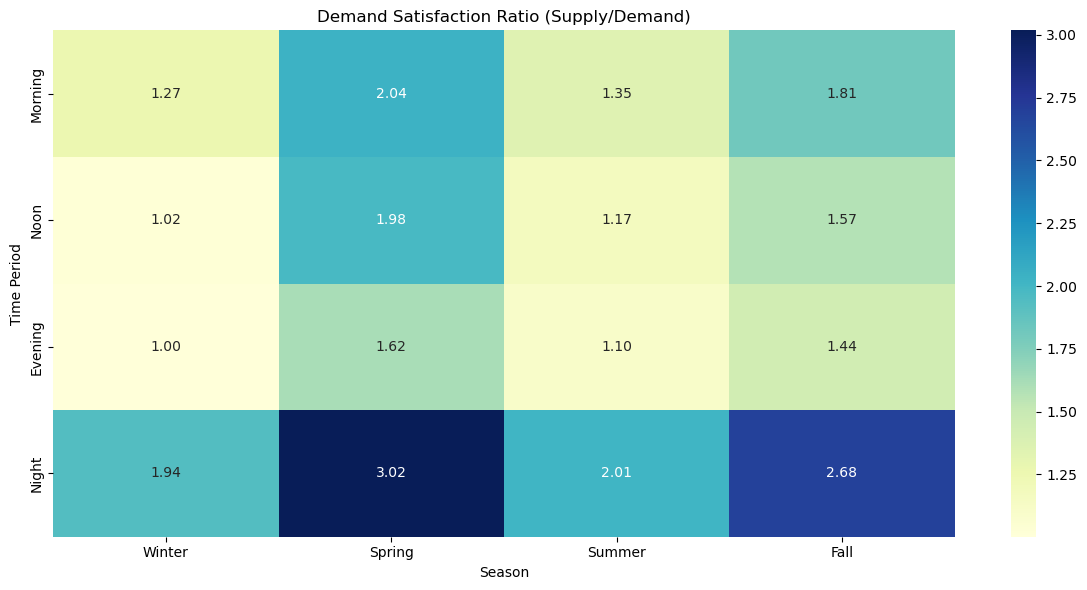

In [68]:
if prob.status == 'optimal':
    # Check if demand is met in all period-season combinations
    demand_satisfaction = np.zeros((len(periods), len(seasons)))
    demand_ratio = np.zeros((len(periods), len(seasons)))
    
    for p in range(len(periods)):
        for s in range(len(seasons)):
            # Calculate total effective production
            total_prod = 0
            for i in range(n):
                if optimal_facilities[i] > 0:
                    total_prod += production[i] * efficiency_3d[i, p, s] * optimal_facilities[i]
            
            demand_satisfaction[p, s] = total_prod
            demand_ratio[p, s] = total_prod / demand[p, s]
    
    # Plot demand satisfaction
    plt.figure(figsize=(12, 6))
    sns.heatmap(demand_ratio, annot=True, fmt=".2f", 
                xticklabels=seasons, yticklabels=periods,
                cmap="YlGnBu")
    plt.title('Demand Satisfaction Ratio (Supply/Demand)')
    plt.ylabel('Time Period')
    plt.xlabel('Season')
    plt.tight_layout()
    plt.show()

## 10. Sensitivity Analysis

In [12]:
# We can investigate how solutions change with different environmental weights
# or with different budget constraints

def solve_with_weights(w_co2, w_air, w_water, budget_val=budget):
    env_impact = w_co2 * co2_emissions + w_air * air_pollution + w_water * water_pollution
    objective = cp.Minimize(cp.sum(cp.multiply(env_impact, x)) * total_hours)
    
    # Update budget constraint
    constraints[0] = cp.sum(cp.multiply(build_cost, x)) <= budget_val
    
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.GLPK_MI)
    
    if prob.status == 'optimal':
        return np.round(x.value).astype(int), prob.value
    else:
        return None, None

# Scenario 1: Prioritize CO2 reduction
facilities_s1, value_s1 = solve_with_weights(0.8, 0.1, 0.1)

# Scenario 2: Prioritize air pollution reduction
facilities_s2, value_s2 = solve_with_weights(0.1, 0.8, 0.1)

# Scenario 3: Prioritize water pollution reduction
facilities_s3, value_s3 = solve_with_weights(0.1, 0.1, 0.8)

# Scenario 4: Equal weights but lower budget
facilities_s4, value_s4 = solve_with_weights(0.33, 0.33, 0.34, budget_val=budget*0.7)

In [13]:
# Compare results across scenarios
scenarios = ['Base Case', 'CO2 Priority', 'Air Priority', 'Water Priority', 'Lower Budget']
all_facilities = [optimal_facilities, facilities_s1, facilities_s2, facilities_s3, facilities_s4]

# Create comparison table
comparison = pd.DataFrame(index=energy_sources)

for i, scenario in enumerate(scenarios):
    if i < len(all_facilities) and all_facilities[i] is not None:
        comparison[scenario] = all_facilities[i]
    
# Display the comparison
comparison.fillna(0, inplace=True)
comparison = comparison.astype(int)
print("Number of Facilities by Scenario:")
comparison

Number of Facilities by Scenario:


,Base Case,CO2 Priority,Air Priority,Water Priority,Lower Budget
Coal,0,0,0,0,0
Natural Gas,0,0,0,0,0
Nuclear,0,0,2,0,0
Hydro,0,0,0,0,0
Solar,5,5,1,5,5
Wind,7,7,4,7,7
Geothermal,0,0,0,0,0


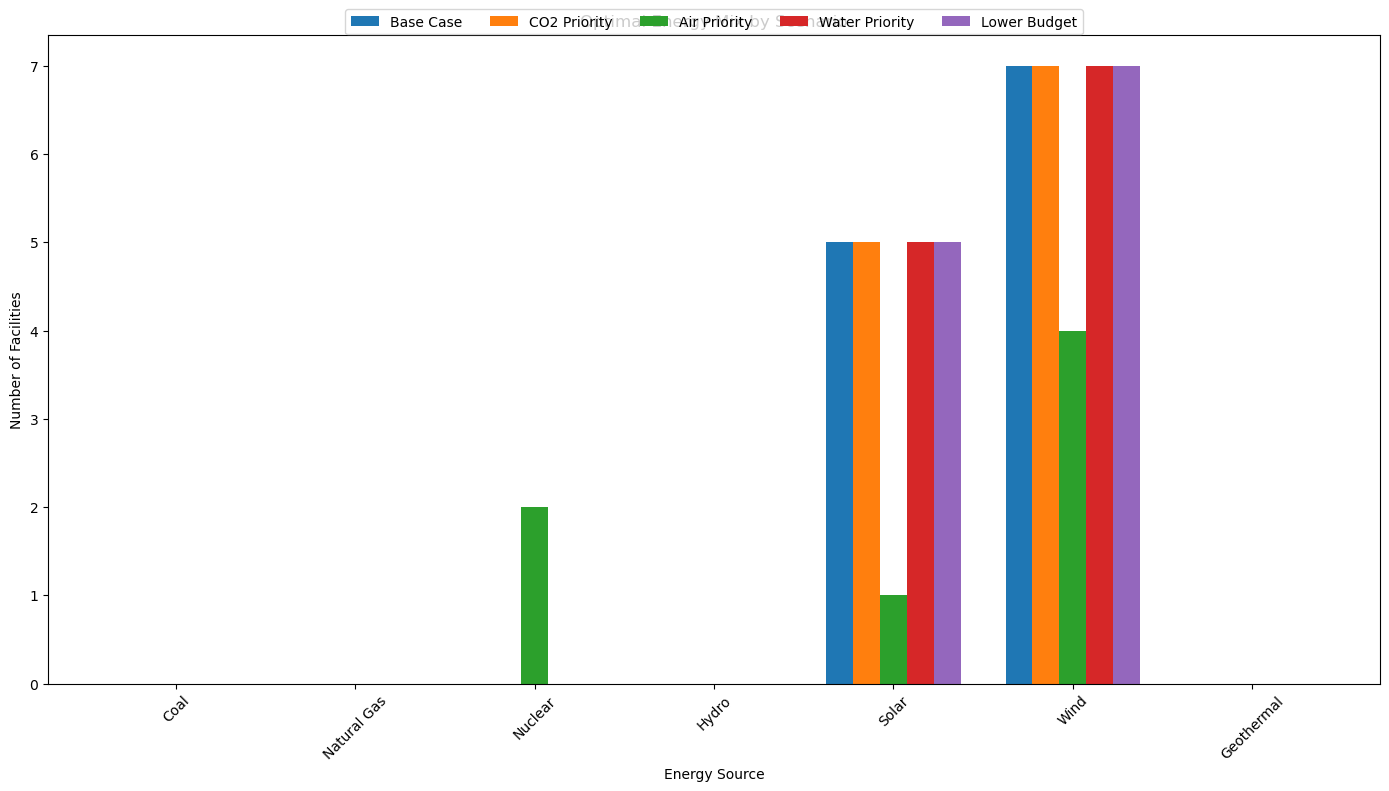

In [14]:
# Visualize the comparison
plt.figure(figsize=(14, 8))

x = np.arange(len(energy_sources))
width = 0.15
multiplier = 0

for attribute, measurement in comparison.items():
    offset = width * multiplier
    rects = plt.bar(x + offset, measurement, width, label=attribute)
    multiplier += 1

plt.ylabel('Number of Facilities')
plt.xlabel('Energy Source')
plt.title('Optimal Energy Mix by Scenario')
plt.xticks(x + width * (len(scenarios)-1)/2, energy_sources, rotation=45)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=len(scenarios))
plt.tight_layout()
plt.show()

## 11. Conclusion

This mathematical optimization model provides a framework for determining the optimal energy production mix to minimize environmental impacts while meeting demand constraints. The model demonstrates that:

1. Different energy sources have varying environmental impacts, production capacities, and costs.
2. The optimal solution depends strongly on how environmental impacts are weighted.
3. Budget constraints significantly affect the available options.
4. Time-of-day and seasonal variations in both demand and production efficiency are critical factors.

Future enhancements could include:
- More granular time periods
- Storage considerations
- Network transmission constraints
- Carbon pricing mechanisms